# Import Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from datasets import load_dataset

import time
# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed)  

In [2]:
#import simplejson as json
import nltk 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tepla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tepla\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\tepla\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


# Create Data

## Get datasets and vectorizers

In [3]:
def get_data(): 
    
    train_data = load_dataset('imdb', split='train')
    train_df = pd.DataFrame(train_data)[['text', 'label']].dropna()
    test_data = load_dataset('imdb', split='test')
    test_df = pd.DataFrame(test_data)[['text', 'label']].dropna()
        
    print('Total number of train data extracted =', len(train_data))
    print('Total number of test data extracted =', len(test_data))

    print('Extracting tokens from each review.....(can be slow for a large number of reviews)......')   
    # do not consider reviews with scores above max_neg and below min_pos (these reviews will be dropped)

    return train_df['text'].tolist(), train_df['label'], test_df['text'].tolist(), test_df['label']
    # create an instance of a CountVectorizer, using 
    # (1) the standard 'english' stopword set 
    # (2) only keeping terms in the vocabulary that occur in at least 1% of documents
    # (3) allowing only unigrams in the vocabulary (use "ngram_range=(1, 1)" to do this)
    '''
    vectorizer = TfidfVectorizer(stop_words='english', min_df=0.005, ngram_range=(1, 3))

    # create a sparse BOW array from 'text' using vectorizer
    X_train = vectorizer.fit_transform(train_df['text'].tolist())
    y_train = train_df['label']
 
    print('Train Data shape: ', X_train.shape[0])

    X_test = vectorizer.transform(test_df['text'].tolist())
    y_test = test_df['label']
    print('Train Data shape: ', X_train.shape[0])
    
    # you can uncomment this next line if you want to see the full list of tokens in the vocabulary  
    #print('Vocabulary: ', vectorizer.get_feature_names())
 
    return X_train, y_train, X_test, y_test, test_df['text'].tolist(), train_df['text'].tolist(), vectorizer 
    '''

In [4]:
train_text, train_label, test_text, test_label = get_data()

Total number of train data extracted = 25000
Total number of test data extracted = 25000
Extracting tokens from each review.....(can be slow for a large number of reviews)......


## Validation

In [5]:
vectorizer_configs = [
    {'type': 'count', 'ngram_range': (1, 1), 'min_df': 0.05},
    {'type': 'count', 'ngram_range': (1, 1), 'min_df': 0.02},
    {'type': 'count', 'ngram_range': (1, 1), 'min_df': 0.01},
    {'type': 'count', 'ngram_range': (1, 2), 'min_df': 0.05},
    {'type': 'count', 'ngram_range': (1, 2), 'min_df': 0.02},
    {'type': 'count', 'ngram_range': (1, 2), 'min_df': 0.01},
    {'type': 'count', 'ngram_range': (1, 3), 'min_df': 0.05},
    {'type': 'count', 'ngram_range': (1, 3), 'min_df': 0.02},
    {'type': 'count', 'ngram_range': (1, 3), 'min_df': 0.01},
    {'type': 'tfidf', 'ngram_range': (1, 1), 'min_df': 0.05},
    {'type': 'tfidf', 'ngram_range': (1, 1), 'min_df': 0.02},
    {'type': 'tfidf', 'ngram_range': (1, 1), 'min_df': 0.01},
    {'type': 'tfidf', 'ngram_range': (1, 2), 'min_df': 0.05},
    {'type': 'tfidf', 'ngram_range': (1, 2), 'min_df': 0.02},
    {'type': 'tfidf', 'ngram_range': (1, 2), 'min_df': 0.01},
    {'type': 'tfidf', 'ngram_range': (1, 3), 'min_df': 0.05},
    {'type': 'tfidf', 'ngram_range': (1, 3), 'min_df': 0.02},
    {'type': 'tfidf', 'ngram_range': (1, 3), 'min_df': 0.01},
]

penalty_list = ['l2', None]
solver_list = ['lbfgs', 'newton-cg', 'newton-cholesky']

In [6]:
X_train_text, X_val_text, y_train, y_val = train_test_split(train_text, train_label, test_size=0.25, random_state=seed)

best_acc = 0
best_config = None
best_vectorizer = None
best_penalty = None
best_solver = None

for config in vectorizer_configs:
    print(f"\nTrying config: {config}")
    
    # Choose vectorizer type
    if config['type'] == 'count':
        vectorizer = CountVectorizer(stop_words='english', 
                                     ngram_range=config['ngram_range'], 
                                     min_df=config['min_df'])
    else:
        vectorizer = TfidfVectorizer(stop_words='english', 
                                     ngram_range=config['ngram_range'], 
                                     min_df=config['min_df'])

    # Fit on training text
    X_train = vectorizer.fit_transform(X_train_text)
    X_val = vectorizer.transform(X_val_text)

    # Train classifier
    for penalty in penalty_list:
        print(f"\nTrying penalty: {penalty}")
        
        for solver in solver_list:
            print(f"\nTrying solver: {solver}")
            
            clf = LogisticRegression(penalty=penalty, solver=solver)
            clf.fit(X_train, y_train)
        
            # Validation accuracy
            val_acc = accuracy_score(y_val, clf.predict(X_val))
            print(f"Validation Accuracy: {val_acc:.4f}")
        
            # Track best
            if val_acc > best_acc:
                best_acc = val_acc
                best_config = config
                best_penalty = penalty
                best_solver = solver
                best_vectorizer = vectorizer


Trying config: {'type': 'count', 'ngram_range': (1, 1), 'min_df': 0.05}

Trying penalty: l2

Trying solver: lbfgs
Validation Accuracy: 0.8090

Trying solver: newton-cg
Validation Accuracy: 0.8086

Trying solver: newton-cholesky
Validation Accuracy: 0.8086

Trying penalty: None

Trying solver: lbfgs
Validation Accuracy: 0.8088

Trying solver: newton-cg
Validation Accuracy: 0.8086

Trying solver: newton-cholesky
Validation Accuracy: 0.8086

Trying config: {'type': 'count', 'ngram_range': (1, 1), 'min_df': 0.02}

Trying penalty: l2

Trying solver: lbfgs
Validation Accuracy: 0.8421

Trying solver: newton-cg
Validation Accuracy: 0.8419

Trying solver: newton-cholesky
Validation Accuracy: 0.8419

Trying penalty: None

Trying solver: lbfgs
Validation Accuracy: 0.8413

Trying solver: newton-cg
Validation Accuracy: 0.8418

Trying solver: newton-cholesky
Validation Accuracy: 0.8418

Trying config: {'type': 'count', 'ngram_range': (1, 1), 'min_df': 0.01}

Trying penalty: l2

Trying solver: lbfgs

D:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8512

Trying solver: newton-cg
Validation Accuracy: 0.8510

Trying solver: newton-cholesky
Validation Accuracy: 0.8510

Trying penalty: None

Trying solver: lbfgs


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8493

Trying solver: newton-cg
Validation Accuracy: 0.8491

Trying solver: newton-cholesky
Validation Accuracy: 0.8490

Trying config: {'type': 'count', 'ngram_range': (1, 2), 'min_df': 0.05}

Trying penalty: l2

Trying solver: lbfgs


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8080

Trying solver: newton-cg
Validation Accuracy: 0.8078

Trying solver: newton-cholesky
Validation Accuracy: 0.8078

Trying penalty: None

Trying solver: lbfgs


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8082

Trying solver: newton-cg
Validation Accuracy: 0.8078

Trying solver: newton-cholesky
Validation Accuracy: 0.8078

Trying config: {'type': 'count', 'ngram_range': (1, 2), 'min_df': 0.02}

Trying penalty: l2

Trying solver: lbfgs


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8434

Trying solver: newton-cg
Validation Accuracy: 0.8435

Trying solver: newton-cholesky
Validation Accuracy: 0.8437

Trying penalty: None

Trying solver: lbfgs


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8440

Trying solver: newton-cg
Validation Accuracy: 0.8437

Trying solver: newton-cholesky
Validation Accuracy: 0.8434

Trying config: {'type': 'count', 'ngram_range': (1, 2), 'min_df': 0.01}

Trying penalty: l2

Trying solver: lbfgs


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8482

Trying solver: newton-cg
Validation Accuracy: 0.8488

Trying solver: newton-cholesky
Validation Accuracy: 0.8485

Trying penalty: None

Trying solver: lbfgs


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8464

Trying solver: newton-cg
Validation Accuracy: 0.8464

Trying solver: newton-cholesky
Validation Accuracy: 0.8462

Trying config: {'type': 'count', 'ngram_range': (1, 3), 'min_df': 0.05}

Trying penalty: l2

Trying solver: lbfgs


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8080

Trying solver: newton-cg
Validation Accuracy: 0.8078

Trying solver: newton-cholesky
Validation Accuracy: 0.8078

Trying penalty: None

Trying solver: lbfgs


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8082

Trying solver: newton-cg
Validation Accuracy: 0.8078

Trying solver: newton-cholesky


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:497: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.77081e-21): result may not be accurate.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:194: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Validation Accuracy: 0.8082

Trying config: {'type': 'count', 'ngram_range': (1, 3), 'min_df': 0.02}

Trying penalty: l2

Trying solver: lbfgs
Validation Accuracy: 0.8438

Trying solver: newton-cg
Validation Accuracy: 0.8435

Trying solver: newton-cholesky
Validation Accuracy: 0.8437

Trying penalty: None

Trying solver: lbfgs


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8434

Trying solver: newton-cg
Validation Accuracy: 0.8437

Trying solver: newton-cholesky


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:497: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.32218e-22): result may not be accurate.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:194: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Validation Accuracy: 0.8434

Trying config: {'type': 'count', 'ngram_range': (1, 3), 'min_df': 0.01}

Trying penalty: l2

Trying solver: lbfgs


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8483

Trying solver: newton-cg
Validation Accuracy: 0.8488

Trying solver: newton-cholesky
Validation Accuracy: 0.8486

Trying penalty: None

Trying solver: lbfgs


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8464

Trying solver: newton-cg
Validation Accuracy: 0.8464

Trying solver: newton-cholesky


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:497: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=4.09626e-40): result may not be accurate.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:194: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Validation Accuracy: 0.8464

Trying config: {'type': 'tfidf', 'ngram_range': (1, 1), 'min_df': 0.05}

Trying penalty: l2

Trying solver: lbfgs
Validation Accuracy: 0.8091

Trying solver: newton-cg
Validation Accuracy: 0.8090

Trying solver: newton-cholesky
Validation Accuracy: 0.8088

Trying penalty: None

Trying solver: lbfgs
Validation Accuracy: 0.8074

Trying solver: newton-cg
Validation Accuracy: 0.8080

Trying solver: newton-cholesky
Validation Accuracy: 0.8080

Trying config: {'type': 'tfidf', 'ngram_range': (1, 1), 'min_df': 0.02}

Trying penalty: l2

Trying solver: lbfgs
Validation Accuracy: 0.8472

Trying solver: newton-cg
Validation Accuracy: 0.8470

Trying solver: newton-cholesky
Validation Accuracy: 0.8472

Trying penalty: None

Trying solver: lbfgs
Validation Accuracy: 0.8434

Trying solver: newton-cg
Validation Accuracy: 0.8443

Trying solver: newton-cholesky
Validation Accuracy: 0.8437

Trying config: {'type': 'tfidf', 'ngram_range': (1, 1), 'min_df': 0.01}

Trying penal

D:\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:497: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.00286e-21): result may not be accurate.
  warnings.warn(


Validation Accuracy: 0.8078

Trying config: {'type': 'tfidf', 'ngram_range': (1, 3), 'min_df': 0.02}

Trying penalty: l2

Trying solver: lbfgs
Validation Accuracy: 0.8486

Trying solver: newton-cg
Validation Accuracy: 0.8486

Trying solver: newton-cholesky
Validation Accuracy: 0.8490

Trying penalty: None

Trying solver: lbfgs
Validation Accuracy: 0.8443

Trying solver: newton-cg
Validation Accuracy: 0.8446

Trying solver: newton-cholesky


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:497: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.87525e-21): result may not be accurate.
  warnings.warn(


Validation Accuracy: 0.8443

Trying config: {'type': 'tfidf', 'ngram_range': (1, 3), 'min_df': 0.01}

Trying penalty: l2

Trying solver: lbfgs
Validation Accuracy: 0.8619

Trying solver: newton-cg
Validation Accuracy: 0.8613

Trying solver: newton-cholesky
Validation Accuracy: 0.8613

Trying penalty: None

Trying solver: lbfgs
Validation Accuracy: 0.8509

Trying solver: newton-cg
Validation Accuracy: 0.8498

Trying solver: newton-cholesky
Validation Accuracy: 0.8509


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:497: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.17615e-39): result may not be accurate.
  warnings.warn(


## Create train and test sets

In [7]:
print("Best Config:", best_config)
print("Best Penalty:", best_penalty)
print("Best Solver:", best_solver)

# Fit vectorizer on entire training set
X_train_set = best_vectorizer.fit_transform(train_text)
y_train_set = train_label

X_test_set = best_vectorizer.transform(test_text)
y_test_set = test_label

Best Config: {'type': 'tfidf', 'ngram_range': (1, 3), 'min_df': 0.01}
Best Penalty: l2
Best Solver: lbfgs


## Get classifier

In [8]:
def logistic_classification(X_train, y_train, X_test, y_test): 
    classifier = LogisticRegression(penalty=best_penalty, solver=best_solver, fit_intercept=True)

    print('\nTraining a model with', X_train.shape[0], 'examples.....')
    classifier.fit(X_train, y_train)
    
    train_accuracy = accuracy_score(y_train, classifier.predict(X_train))
    print('\nTraining accuracy:', format(100 * train_accuracy, '.2f'))

    test_accuracy = accuracy_score(y_test, classifier.predict(X_test))
    print('\nTesting accuracy:', format(100 * test_accuracy, '.2f'))

    return classifier, train_accuracy, test_accuracy

In [9]:
logistic_classifier, _, _= logistic_classification(X_train_set, y_train_set, X_test_set, y_test_set)


Training a model with 25000 examples.....

Training accuracy: 88.98

Testing accuracy: 86.92


# Data analysis

## Histogram

In [10]:
def review_word_count_histgram(X):
    '''
    X:  [# feature vectors, # features], feature vectors
    '''
    ### YOUR CODE STARTS HERE ###

    word_count = X.getnnz(axis=1)

    plt.figure(figsize=(8, 5))
    plt.hist(word_count, bins=30)
    plt.show()
    ### YOUR CODE ENDS HERE ###

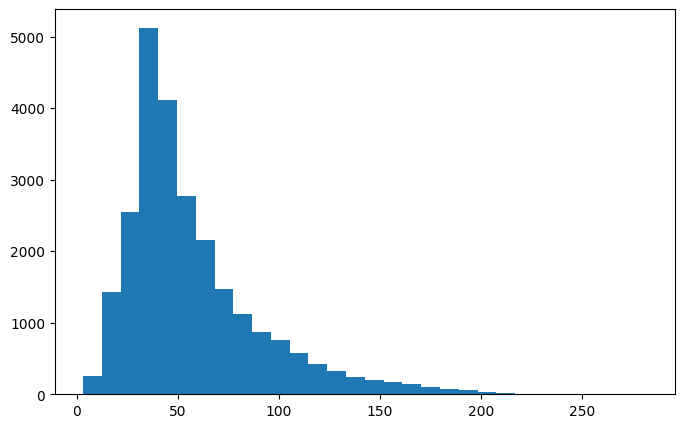

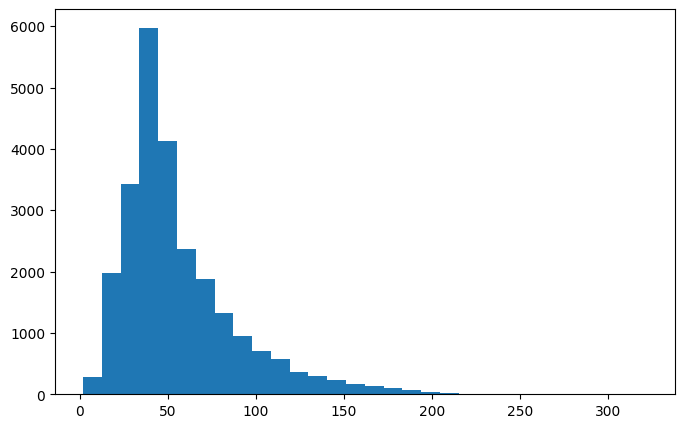

In [11]:
review_word_count_histgram(X_train_set)
review_word_count_histgram(X_test_set)

## Most significant terms

In [12]:
def most_significant_terms(classifier, vectorizer, K):
    # cycle through the positive weights, in the order of largest weight first and print out
    # K lines where each line contains
    # (a) the term corresponding to the weight (a string)
    # (b) the weight value itself (a scalar printed to 3 decimal places)

    ### YOUR CODE STARTS HERE ###
    # extract coefficients from trained model and sort based on coefficient
    feature_importance = classifier.coef_[0]
    # the index of sorted coefficient
    sorted_idx = np.argsort(feature_importance)
    # extract topK positive terms
    topK_pos_terms = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(w)] for w in
                      sorted_idx[-K:]][::-1]
    # extract corresponding weights
    topK_pos_weights = np.round(np.array([feature_importance[w] for w in sorted_idx[-K:][::-1]]), decimals=3)

    topK_neg_terms = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(w)] for w in
                      sorted_idx[:K]]
    topK_neg_weights = np.round(np.array([feature_importance[w] for w in sorted_idx[:K]]), decimals=3)

    ### YOUR CODE ENDS HERE ###
    print('topK_pos_weights', topK_pos_weights)
    print('topK_pos_terms', topK_pos_terms)
    print('topK_neg_weights', topK_neg_weights)
    print('topK_neg_terms',topK_neg_terms)
    return topK_pos_weights, topK_pos_terms, topK_neg_weights, topK_neg_terms

In [13]:
topK_pos_weights, topK_pos_terms, topK_neg_weights, topK_neg_terms = most_significant_terms(logistic_classifier, best_vectorizer, K=10)

topK_pos_weights [5.83  5.751 4.747 4.743 4.664 4.236 4.233 3.59  3.51  3.486]
topK_pos_terms ['excellent', 'great', 'best', 'perfect', 'wonderful', 'amazing', 'favorite', 'loved', 'today', 'superb']
topK_neg_weights [-8.793 -6.504 -5.855 -5.753 -5.428 -4.863 -4.858 -4.838 -4.768 -4.545]
topK_neg_terms ['worst', 'awful', 'bad', 'waste', 'boring', 'poor', 'worse', 'dull', 'poorly', 'disappointment']


## Accuracy vs reguralization strength

In [14]:
def accuracy_vs_reg(X_train, y_train, X_test, y_test):
    # log initialization
    coefs_ = []
    train_accuracies = []
    test_accuracies = []
    cs = [0, 0.1, 1, 10, 50]

    ### YOUR CODE STARTS HERE ###
    for c in cs:
        # Specify the logistic classifier model
        if c == 0:
            classifier = LogisticRegression(penalty=None, fit_intercept=True)
        else:
            # Refer https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
            # to see which argument can adjust the regularization strength,
            # Additionally, please use 'l1' penalty type, 'liblinear' solver and enable fit_intercept
            classifier = LogisticRegression(penalty=best_penalty, solver=best_solver, C=c, fit_intercept=True)

        classifier.fit(X_train, y_train.values.ravel())

        # log model coefficients
        coefs_.append(classifier.coef_)

        # Training
        train_predictions = classifier.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_accuracies.append(train_accuracy)
        
        # Testing: compute and print accuracy and AUC on the test data
        test_predictions = classifier.predict(X_test)
        test_accuracy = accuracy_score(y_test, test_predictions)
        test_accuracies.append(test_accuracy)

    ### YOUR CODE ENDS HERE ###
    fig, axes = plt.subplots()
    axes.xaxis.set_inverted(True)
    axes.semilogx(cs, train_accuracies, color='red', label='training accuracy')
    axes.semilogx(cs, test_accuracies, color='blue', label='testing accuracy')
    
    axes.set_xlabel('regularization strength', fontsize=14)
    axes.set_ylabel('accuracy', fontsize=14)
    
    axes.legend()

    return train_accuracies, test_accuracies, coefs_

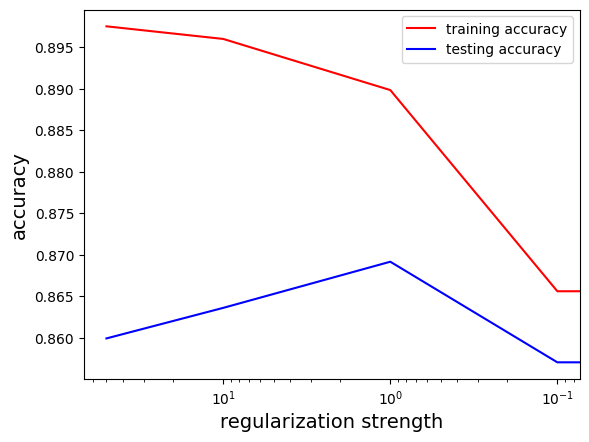

In [15]:
train_accuracies, test_accuracies, coefs = accuracy_vs_reg(X_train_set, y_train_set, X_test_set, y_test_set)

## Time per 1000 examples

In [16]:
start_time = time.time()
logistic_classifier.predict(X_test_set)
end_time = time.time()

total_time = (end_time - start_time)
avg_time = total_time / X_test_set.shape[0]
print(f"Total time taken: {total_time} seconds")
print(f"Avg prediction time per examples: {avg_time * 1000:.5f} milliseconds")

Total time taken: 0.005001068115234375 seconds
Avg prediction time per examples: 0.00020 milliseconds


In [17]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

y_proba = logistic_classifier.predict_proba(X_test_set)[:, 1]
print("AUC:", roc_auc_score(y_test_set, y_proba))

print("Confusion Matrix:")
print(confusion_matrix(y_test_set, logistic_classifier.predict(X_test_set)))

print("Classification Report:")
print(classification_report(y_test_set, logistic_classifier.predict(X_test_set)))

AUC: 0.9437343359999998
Confusion Matrix:
[[10735  1765]
 [ 1506 10994]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.86      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



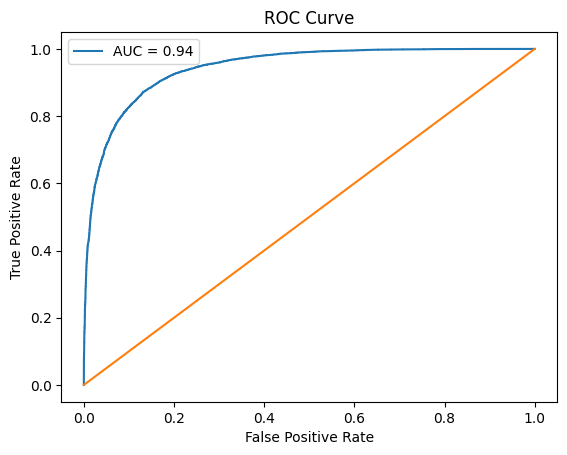

In [18]:
fpr, tpr, _ = roc_curve(y_test_set, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test_set, y_proba):.2f}')
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [19]:
false_positives = np.where((y_test_set == 0) & (logistic_classifier.predict(X_test_set) == 1))[0]
false_negatives = np.where((y_test_set == 1) & (logistic_classifier.predict(X_test_set) == 0))[0]

# Print examples
print("False Positive Example:")
print(test_text[false_positives[0]])

print()

print("False Negative Example:")
print(test_text[false_negatives[0]])

False Positive Example:
First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy these kinds of movies for what they are. This movie is much better than any of the movies the other action guys (Segal and Dolph) have thought about putting out the past few years. Van Damme is good in the movie, the movie is only worth watching to Van Damme fans. It is not as good as Wake of Death (which i highly recommend to anyone of likes Van Damme) or In hell but, in my opinion it's worth watching. It has the same type of feel to it as Nowhere to Run. Good fun stuff!

False Negative Example:
It is more a subtle story of the fact that in Indian household how most decisions are taken by the man, how no attention is paid to the desires of the lady, for example how even when the husband and wife sleep together it would be a test for the husband whether he can control h

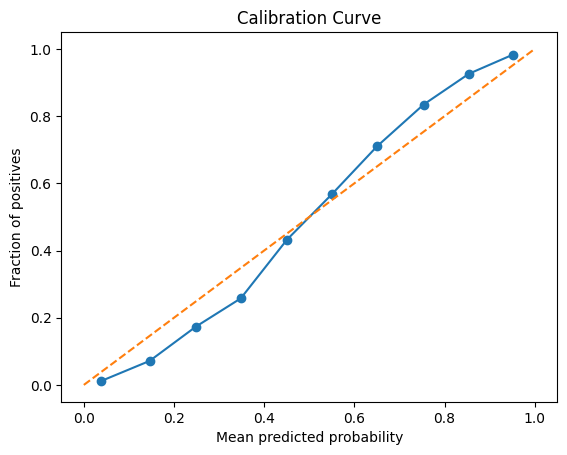

In [20]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test_set, y_proba, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.show()